In [1]:
import os
print(os.getcwd())
os.chdir('research_files')

/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings
import heapq
import lightgbm as lgb
data_original = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')

data = pd.read_csv('privacy_utility_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)



In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]

features_temp = [
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]

print(len(features_temp))
target_sing = 'singling_out_risk'



20


In [4]:
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            # Appending 0 if first is greater, otherwise 1
            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result

def our_ml(dataset, test_size, our_features, target, estimators, learning_rate, depth,  scalee, p = 0):
    
    
  
    

    split_index = int((1 - test_size) * len(data))
    X = dataset[list(our_features)]
    y = dataset[target]
    if scalee == 1:
            continuous_ones = [i for i in our_features if i != 'epsilon']

            X_scaled = X.copy()
            X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])

            # X_train = X.iloc[:split_index]
            # X_test = X.iloc[split_index:]  
            X_train = X_scaled.iloc[:split_index]
            X_test = X_scaled.iloc[split_index:]
            
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]



    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = gb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if p == 0:
        print('Conditions:')
        print(f'Size: {len(dataset)}')
        print(f'Test size percent is: {test_size}')
        print(f'Attributes: {our_features}')
        # print('Actual')
        # print(list(y_test))
        # print('Prediction')
        # print(y_pred)
        # Calculate MSE and R²
        

        print("Gradient Boosting MSE:", mse)
        print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_

    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        
        
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
        if p ==0:
            print(aa)
            print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {acc} %')
            
            print('Prediction vs Actual')
        y_test_2 = list(y_test)
        # ll = 0
        # mm = 0
        # for i in range(len(y_pred)):
        #     ll += 1
        #     print(f'{y_pred[i]}  -  {y_test_2[i]}' )
        #     if ll % 2 == 0:
        #         print(aa[mm])
        #         mm += 1
        #         print('\n')
            # ...
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0
        acc = 0


  
    return gb_model, y_pred, y_test_2, importances,  mse, r2, acc


def lightgbm_ml(our_data, our_features, target, perc, scalee, n_estimators=100, learning_rate=0.1, depth=-1, p = 0):
    warnings.simplefilter(action='ignore', category=UserWarning)
    test_size = perc
    split_index = int((1 - test_size) * len(our_data))
    X = our_data[list(our_features)]
    y = our_data[target]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]

    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    # model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1)
    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1, max_depth = depth,   n_jobs=2
                                  )
    # model = lgb.LGBMRegressor(
    #     n_estimators=n_estimators,       
    #     learning_rate=learning_rate,      
    #     max_depth=depth,                 
    #     num_leaves=2**depth,             
    #     min_child_samples=20,             
    #     subsample=1.0,                    
    #     colsample_bytree=1.0,             
    #     random_state=42,                  
    #     feature_fraction_bynode=1.0,      
    #     boosting_type='gbdt',             
    #     importance_type='split',          
    #     extra_trees=False,               
    #     min_split_gain=0,                 
    #     reg_alpha=0.0,                    
    #     reg_lambda=0.0,                    
    #     verbose=-1                        
    # )
    
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  # Ensure no negative predictions
    
    # Calculate MSE and R²
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
        aa = []
        y_test_2 = y_test.reset_index(drop=True)
        y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
        res_act = comp_func(y_test_2)
        res_pred = comp_func(y_pred_2)
        
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        # print(aa)            
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
    else:
        aa = []
        acc = 0
    if p == 0:
        print('\n')
        print(f'Conditions for {target}:')
        print("LightGBM Regression")
        if scalee == 1:
            print("With Scaler")
        print(f'Number of Estimators: {n_estimators}')
        print(f'Learning Rate: {learning_rate}')
        print(f"Best MSE: {mse:.10f}")
        print(f"Best R²: {r2:.10f}")
        print(f'Test size: {perc}')
        print(f"Best Feature Combination: {our_features}")
        # print(aa)
        print(f'Accuracy: {acc}%')
    
    # print("Feature Importances:")
    single_importances_series = pd.Series(model.feature_importances_ , index=our_features)
    importances_percentages = (single_importances_series / single_importances_series.sum())
    # print(importances_percentages)
    # print("\nPredicted vs Actual Values:")
    # print("{:<15} {:<15}".format("Predicted", "Actual"))
    # i = 0
    # j = 0
    # for pred, actual in zip(y_pred, y_test):
    #     i += 1
    #     print("{:<15} {:<15}".format(pred, actual))
    #     if i == 2:
    #         print(aa[j])
    #         print('\n')
    #         i = 0
    #         j += 1
        
    
    # importances_sorted = single_importances_series.sort_values(ascending=False)
    return model, y_pred.tolist(), y_test.tolist(), importances_percentages, mse, r2,  acc







In [ ]:
pd.options.display.float_format = '{:.10f}'.format

In [5]:

import pandas as pd

def bfs_feature_selection(data, features, target, test_size, n_estimators=100, learning_rate=0.1, depth=-1, max_depth_tree=10, max_features='sqrt', max_samples=0.8):
    best_mse = float('inf')
    best_r2 = 0
    best_features = None
    best_model = None
    visited = set()
    evaluation_count = 0

    # Priority queue for Best-First Search
    priority_queue = []

    # Start with the initial combination containing only 'epsilon'
    initial_features = ['epsilon'
                        # , 'kurtosis', 
                        # 'size_mb', 
                        # 'min_categorical_unique', 
                        #  
                        # 'skewness',
                        #   'num_categorical_attributes'
                        ]
    heapq.heappush(priority_queue, (float('-inf'), initial_features))

    print("Starting BFS feature selection...")

    while priority_queue:
        current_r2, current_features = heapq.heappop(priority_queue)

        current_features_tuple = tuple(sorted(current_features))
        if current_features_tuple in visited:
            continue

        visited.add(current_features_tuple)

        # Prepare the data with the current feature set
        X = data[current_features]
        y = data[target]

        if X.empty or y.empty:
            print(f"Skipping empty data slice for features: {current_features}")
            continue
            # We are using here last 19% for test
        split_index = int((1 - test_size) * len(data)) 
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if X_train.empty or y_train.empty:
            print(f"Skipping empty training data for features: {current_features}")
            continue

        model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1, max_depth = depth,   n_jobs=2
                                  )

        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error fitting model with features: {current_features}, Error: {e}")
            continue

        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Ensure that both y_pred and y_test are even length and perform comparison
        if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
            aa = []
            y_test_2 = y_test.reset_index(drop=True)
            y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
            res_act = comp_func(y_test_2)  # Ensure comp_func is defined
            res_pred = comp_func(y_pred_2)
            for i in range(len(res_act)):
                aa.append(res_act[i] == res_pred[i])

            acc = (aa.count(True) / len(aa)) * 100
        else:
            acc = 0

        evaluation_count += 1

        # Update the best result if r2 improves
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_features = current_features
            best_acc = acc
            best_model = model
            
            print(f"\nNew best R²: {best_r2:.10f}, MSE: {best_mse:.10f}, Compare Accuracy: {best_acc:.2f}% with features: {best_features}")
            # print(len(best_features))

        if evaluation_count % 200 == 0:
            print(f"\rEvaluated {evaluation_count} combinations so far...", end='', flush=True)

        # Generate new combinations by adding one more feature to the current set
        for feature in features:
            if feature not in current_features:
                new_features = current_features + [feature]
                # Push -r2 to prioritize higher R² values
                heapq.heappush(priority_queue, (-r2, new_features))

    print("\nBFS complete.")
    print(f"Best feature combination: {best_features}")
    print(f"Best R²: {best_r2:.10f}")
    print(f"Best MSE: {best_mse:.10f}")

    return best_model, best_features, best_mse, best_r2


In [ ]:
bfs_feature_selection(data, features_temp, target_sing, 0.19, learning_rate = 0.1, n_estimators=100)

"""
After 5 minutes
Evaluated 29800 combinations so far...
New best R²: 0.4029473913, MSE: 0.0000248694, Compare Accuracy: 75.86% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']

"""

Starting BFS feature selection...

New best R²: 0.0056569291, MSE: 0.0000414179, Compare Accuracy: 13.79% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis']

New best R²: 0.0139888387, MSE: 0.0000410709, Compare Accuracy: 20.69% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'avg_cat_uniqueness_ratio']

New best R²: 0.0236876393, MSE: 0.0000406669, Compare Accuracy: 20.69% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'avg_cat_uniqueness_ratio', 'mean_categorical_unique']

New best R²: 0.1557845175, MSE: 0.0000351646, Compare Accuracy: 75.86% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'avg_cat_uniqueness_ratio', 'mean_categorical_unique', 'num_records']

New best R²: 0.1920440088, MSE: 0.0000336543, Compare Accuracy: 24.14% with features: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'avg_cat_uniqueness_ratio', 'mean_categorical_unique', 'num_records', 'max_continuous_correlation']

New bes

KeyboardInterrupt: 

In [7]:
best_features = ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 
       'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']

single_ml, single_predictions, single_actual, single_importances, single_mse, single_r2, single_acc = lightgbm_ml(data, best_features, target_sing, 0.19, 0, 100, 0.1)



Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000248694
Best R²: 0.4029473913
Test size: 0.19
Best Feature Combination: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']
Accuracy: 75.86206896551724%


In [ ]:
best_actual_0 = [single_actual[i] for i in range(0, len(single_actual), 2)]   # Actual values for epsilon 0
best_actual_01 = [single_actual[i] for i in range(1, len(single_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [single_predictions[i] for i in range(0, len(single_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [single_predictions[i] for i in range(1, len(single_predictions), 2)] # Predicted values for epsilon 0.1


x_indices_0 = range(len(best_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(best_actual_01))   # Indices for epsilon 0.1
y_min = 0
# y_max = max(max(best_actual_0), max(best_actual_01), max(y_pred_0), max(y_pred_01)) + 0.1
y_max = 0.1
# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)
plt.title('Singling Out Risk Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
# plt.savefig('singling_out_difference_between_actual_values.png') 
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Singling Out Risk Difference between Predicted Values (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_brute_difference_between_predicted_values.png') 
plt.show()

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.title('Actual vs Predicted Singling Out Risk with Epsilon Value 0 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_brute_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.title('Actual vs Predicted Singling Out Risk with Epsilon Value 0.1 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_brute_actual_vs_predicted_epsilon_01.png')  
plt.show()


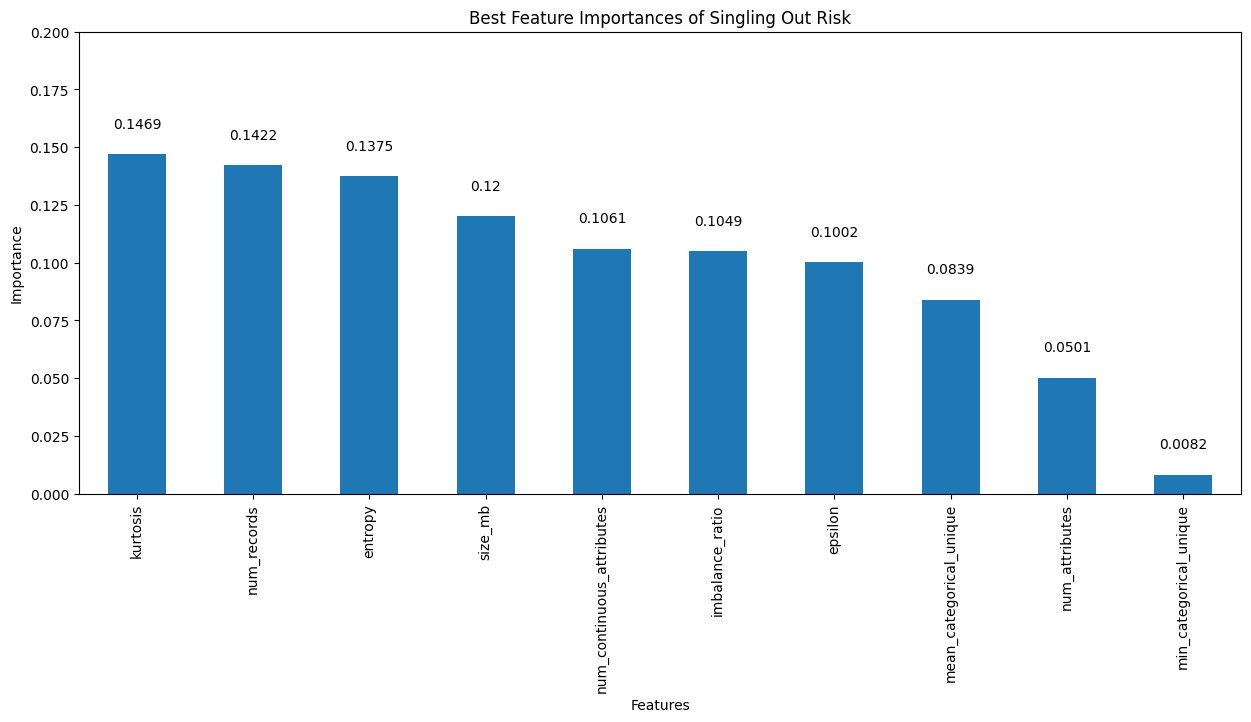

In [8]:


"""
Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000248694
Best R²: 0.4029473913
Test size: 0.19
Best Feature Combination: ['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']
Accuracy: 82.75862068965517
"""
first_importances_sorted = single_importances.sort_values(ascending=False)
plt.figure(figsize=(15, 6))
plt.ylim(0, 0.2)
ax = first_importances_sorted.plot(kind='bar')
for i, v in enumerate(first_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.title('Best Feature Importances of Singling Out Risk')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()


<class 'pandas.core.series.Series'>
['epsilon', 'entropy', 'imbalance_ratio', 'kurtosis', 'num_records', 'size_mb', 'num_continuous_attributes', 'num_attributes', 'mean_categorical_unique', 'min_categorical_unique']

Importances Sorted
['kurtosis', 'num_records', 'entropy', 'size_mb', 'num_continuous_attributes', 'imbalance_ratio', 'epsilon', 'mean_categorical_unique', 'num_attributes', 'min_categorical_unique']


Conditions for singling_out_risk:
LightGBM Regression
Number of Estimators: 100
Learning Rate: 0.1
Best MSE: 0.0000248694
Best R²: 0.4029473913
Test size: 0.19
Best Feature Combination: ['kurtosis', 'num_records', 'entropy', 'size_mb', 'num_continuous_attributes', 'imbalance_ratio', 'epsilon', 'mean_categorical_unique', 'num_attributes', 'min_categorical_unique']
Accuracy: 75.86206896551724%


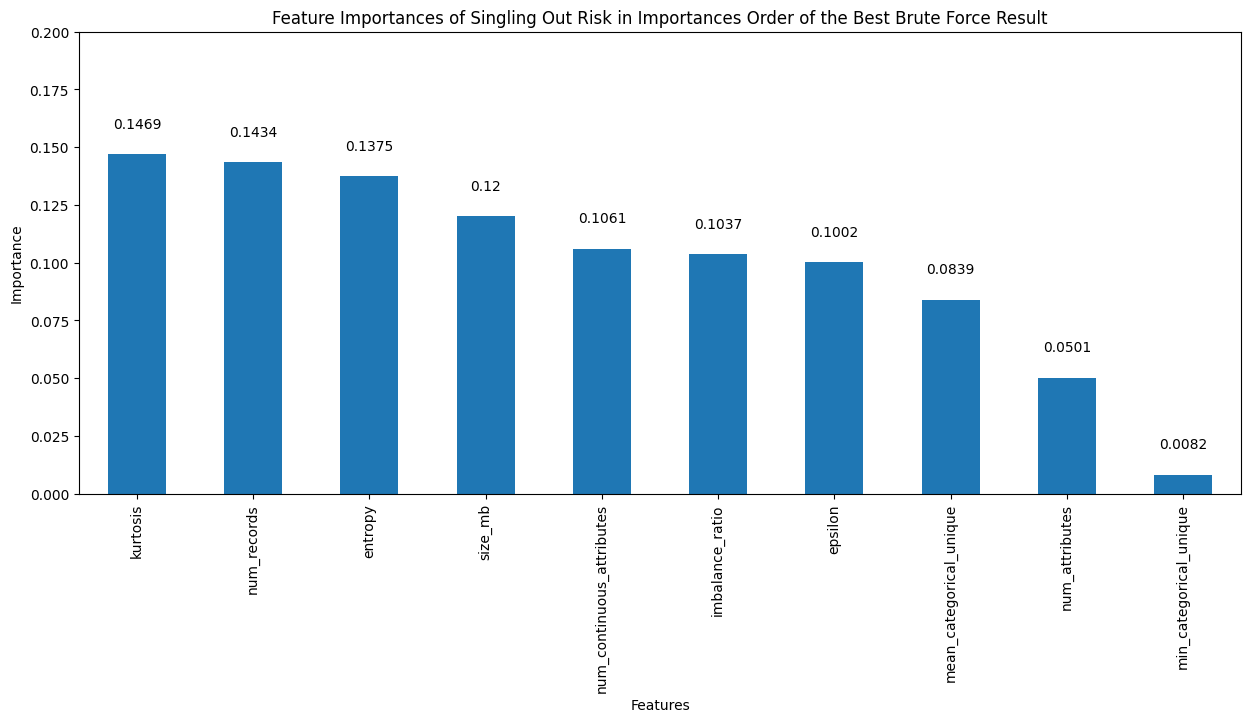

'\nBEst:\nBest MSE: 0.0000248694\nBest R²: 0.4029473913\nAccuracy: 82.75862068965517%\n\nBest MSE: 0.0000248694\nBest R²: 0.4029473913\n\n '

In [ ]:
print(type(single_importances))
# first_importances_sorted = single_importances.sort_values(ascending=False)

fffff = first_importances_sorted.index.tolist()
print(best_features)
print('\nImportances Sorted')
print(fffff)

ee0, ee1, ee2, ee3_importances, ee4, ee5, ee6  = lightgbm_ml(data, fffff, target_sing, 0.19, 0, 100, 0.1)
ee3_importances_sorted = ee3_importances.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
ax = ee3_importances_sorted.plot(kind='bar')
for i, v in enumerate(ee3_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
    plt.ylim(0, 0.2)
plt.title('Feature Importances of Singling Out Risk in Importances Order of the Best Brute Force Result')
plt.xlabel('Features')
plt.ylabel('Importance')

# plt.savefig('energy_importances.png')
plt.show()
"""
BEst:
Best MSE: 0.0000248694
Best R²: 0.4029473913

Best MSE: 0.0000248694
Best R²: 0.4029473913

 """

In [ ]:
print(data.describe())


y_min = 0
y_max = 150
x_min = 0
x_max = 0.4


singling_0 = data[data['epsilon'] == 0]
singling_01 = data[data['epsilon'] == 0.1]

print(len(singling_0))
print(len(singling_01))
# Histogram of the target variable
sns.histplot(data[target_sing], kde=True)
plt.title('Distribution of Singling Out')
plt.savefig('singling_out_distribution.png') 
plt.show()

sns.histplot(singling_0[target_sing], kde=True, bins=50)
plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)
plt.title('Distribution of Singling Out without Differential Privacy')
plt.savefig('singling_out_distribution_0.png') 
plt.show()

sns.histplot(singling_01[target_sing], kde=True, bins=50)
plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)
plt.title('Distribution of Singling Out with Differential Privacy (e = 0.1)')
plt.savefig('singling_out_distribution_01.png') 
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Separate the data by epsilon
single_actual_0 = [single_actual[i] for i in range(0, len(single_actual), 2) ]   # Actual values for epsilon 0
single_actual_01 = [single_actual[i] for i in range(1, len(single_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [single_predictions[i] for i in range(0, len(single_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [single_predictions[i] for i in range(1, len(single_predictions), 2)] # Predicted values for epsilon 0.1

# Generate the x-axis indices
x_indices_0 = range(len(single_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(single_actual_01))   # Indices for epsilon 0.1
y_min = min(min(single_actual_0), min(single_actual_01), min(y_pred_0), min(y_pred_01)) - 0.01
y_max = max(max(single_actual_0), max(single_actual_01), max(y_pred_0), max(y_pred_01)) + 0.01
# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, single_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, single_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max) 
plt.title('Singling Out Risk Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_difference_between_actual_values.png')  
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Singling Out Risk Difference between Predicted Values')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_difference_between_predicted_values.png') 
plt.show()

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, single_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Actual vs Predicted Singling Out Risk (epsilon=0)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_actual_vs_predicted_epsilon_0.png') 
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, single_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Actual vs Predicted Singling Out Risk (epsilon=0.1)')
plt.xlabel('Dataset')
plt.ylabel('Singling Out Risk')
plt.legend()
plt.savefig('singling_out_actual_vs_predicted_epsilon_01.png') 
plt.show()



In [ ]:
# Sort the importances

importances_sorted = single_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
ax = importances_sorted.plot(kind='bar')
for i, v in enumerate(importances_sorted.values):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.title('Feature Importances of Singling Out Risk Estimation')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('singling_out_importances.png')
plt.show()